In [11]:
library(zoo)
library(forecast)

Warning message:
"package 'zoo' was built under R version 3.3.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'forecast' was built under R version 3.3.3"

In [3]:
data_dir <- "C:/Users/Tom/Documents/research/alc-summary"

In [1]:
preprocessing <- function(ts_csv, total_csv, thres=5000){
  
  # removes rows with low observations and locfs them
  # returns time series and total time series, as a list
  
  
  ts = read.csv(ts_csv)
  total <- read.csv(total_csv)
  df = time_index(data.frame(ts))
  df_total = time_index(data.frame(total))
  
  missing = df_total[,'tweets']<thres
  print(which(missing))
  df_total[missing, 'tweets'] <- NA
  df[missing,] <-NA
  df_total = na.locf(df_total[,'tweets'])
  df_filled = (na.locf(df[, ncol(df)]))
  
  return(list(series=df_filled, total=df_total))
}

In [9]:
time_index <- function(df){
  #indexes a dataframe by 30 days and 24 hours
  
  times = data.frame()
  for (d in 1:30){
    for (h in 0:23){
      times = rbind(times, c(d, h, 0))
    }
  }
  colnames(times) = c('day', 'hour', 'tweets')
  colnames(df) = c('day', 'hour', 'tweets')
  merged = merge(times, df, by=c('day', 'hour'), all='TRUE')
  merged[is.na(merged)] = 0
  merged['tweets'] = pmax(merged$tweets.x,merged$tweets.y)
  return (merged)
}


In [37]:
series.std <- function(count, tot){
        # calculate variance of perc as mean of iid rvs (count 1s, tot-count 0s)
        # WE USE CLT
        perc <- count/tot
        # E(X)^2 - E(X)^2
        var <- count/tot - perc*perc
        # CLT: std (y_bar = std(y)/sqrt(n))
        return (sqrt(var)/sqrt(tot))
}

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


png 
  2

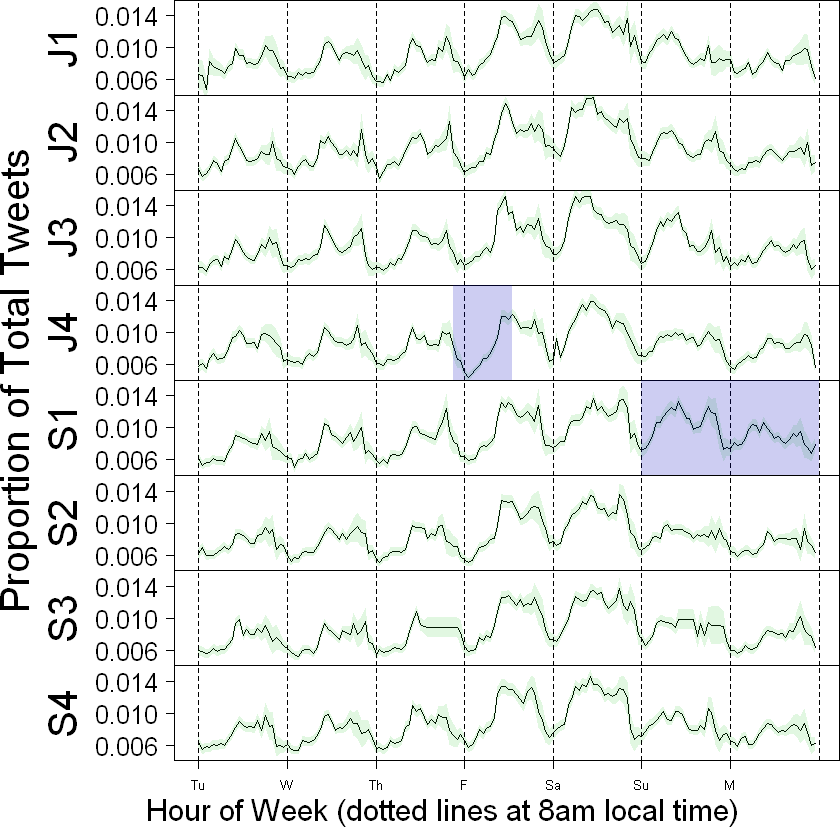

In [116]:
june = preprocessing(paste(data_dir,'/june/june_casual.csv', sep=''), paste(data_dir,'/june/june_total.csv', sep=''))
june_cas = ts(june$series[33:(672+32)], frequency=24)
june_tot = ts(june$total[33:(672+32)], frequency=24)
june_perc <- june_cas/june_tot

sept = preprocessing(paste(data_dir,'/sept/sept_casual.csv', sep=''), paste(data_dir,'/sept/sept_total.csv', sep=''))
sept_cas = ts(sept$series[9:(672+8)], frequency=24)
sept_tot = ts(sept$total[9:(672+8)], frequency=24)
sept_perc <- sept_cas/sept_tot

sept.1 = as.numeric(window(sept_perc, start=c(1, 1), end= c(7, 24)))
sept.2 = as.numeric(window(sept_perc, start=c(8, 1), end= c(14, 24)))
sept.3 = as.numeric(window(sept_perc, start=c(15, 1), end= c(21, 24)))
sept.4 = as.numeric(window(sept_perc, start=c(22, 1), end= c(28, 24)))
june.1 = as.numeric(window(june_perc, start=c(1, 1), end= c(7, 24)))
june.2 = as.numeric(window(june_perc, start=c(8, 1), end= c(14, 24)))
june.3 = as.numeric(window(june_perc, start=c(15, 1), end= c(21, 24)))
june.4 = as.numeric(window(june_perc, start=c(22, 1), end= c(28, 24)))
weeks.perc = data.frame(june.1, june.2, june.3, june.4, sept.1, sept.2, sept.3, sept.4)

sept.t1 = as.numeric(window(sept_tot, start=c(1, 1), end= c(7, 24)))
sept.t2 = as.numeric(window(sept_tot, start=c(8, 1), end= c(14, 24)))
sept.t3 = as.numeric(window(sept_tot, start=c(15, 1), end= c(21, 24)))
sept.t4 = as.numeric(window(sept_tot, start=c(22, 1), end= c(28, 24)))
june.t1 = as.numeric(window(june_tot, start=c(1, 1), end= c(7, 24)))
june.t2 = as.numeric(window(june_tot, start=c(8, 1), end= c(14, 24)))
june.t3 = as.numeric(window(june_tot, start=c(15, 1), end= c(21, 24)))
june.t4 = as.numeric(window(june_tot, start=c(22, 1), end= c(28, 24)))
weeks.tot = data.frame(june.t1, june.t2, june.t3, june.t4, sept.t1, sept.t2, sept.t3, sept.t4)
                           

plot_weeks <- function(perc.df, tot.df){
    
    week_names = c('J1', 'J2', 'J3', 'J4', 'S1', 'S2', 'S3', 'S4')
    par(mfrow=c(8,1))
    # outer margin
    par(oma = c(5, 3, 0, 0))

    shade_color <- rgb(0, 0, 190, alpha=50, maxColorValue=255)
    std_color <- rgb(0, 190, 0, alpha=30, maxColorValue=255)
    
    # plot each week
    for (col in 1:8){
        # remove space for x-axis
        par(mar = c(0, 8, 0, 0))
        yrange = c(0.0045, 0.0155)
        week.std = 1.96*series.std(perc.df[,col]*tot.df[,col], tot.df[,col])
        plot(perc.df[, col], type='l', xaxt='n', ylim=yrange, yaxt='n', ylab='')
        above = perc.df[, col] + week.std
        below = perc.df[, col] - week.std
        polygon(c(1:168, rev(1:168)), c(above, rev(below)), col = std_color, border = NA)
        title(cex.lab =3, ylab=week_names[col], line=6)
        axis(2, labels = c('0.006', '0.010', '0.014'), at=c(0.006, 0.01, 0.014), las = 1, cex.axis=2)
        abline(v=seq(1, (168+24), by=24), lty=2)
        if (col==4){
            rect(xleft=70, xright=86, ybottom=(yrange[1]-0.005), ytop=(yrange[2]+0.005),col=shade_color, border=NA)
            }
        if (col==5){
            rect(xleft=(24*5+1), xright=(24*7+1), ybottom=(yrange[1]-0.005), ytop=(yrange[2]+0.005),col=shade_color, border=NA)
            }

    }

    mtext('Proportion of Total Tweets', cex=2, side = 2, outer = TRUE, line = 1)
    mtext('Hour of Week (dotted lines at 8am local time)', cex=1.5, side = 1, outer = TRUE, line = 3)
    axis(1, labels = c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'), at=seq(1, 168, by=24), outer=TRUE)


}

plot_weeks(weeks.perc, weeks.tot)
pdf('c:/users/tom/documents/research/alc-plots/alc-series.pdf',width=6,height=12,paper='special') 
plot_weeks(weeks.perc, weeks.tot)
dev.off()

In [80]:
june_over = preprocessing(paste(data_dir,'/age/summary/over/casual.csv', sep=''), paste(data_dir,'/june/june_total.csv', sep=''))
june_under = preprocessing(paste(data_dir,'/age/summary/under/casual.csv', sep=''), paste(data_dir,'/june/june_total.csv', sep=''))
tot = ts((june_over$total)[(49-16):(24*30-16)], frequency=24)
jo = ts((june_over$series)[(49-16):(24*30-16)], frequency=24)
ju = ts((june_under$series)[(49-16):(24*30-16)], frequency=24)

o.1 = as.numeric(window(jo, start=c(1, 1), end= c(7, 24)))
o.2 = as.numeric(window(jo, start=c(8, 1), end= c(14, 24)))
o.3 = as.numeric(window(jo, start=c(15, 1), end= c(21, 24)))
o.4 = as.numeric(window(jo, start=c(22, 1), end= c(28, 24)))
u.1 = as.numeric(window(ju, start=c(1, 1), end= c(7, 24)))
u.2 = as.numeric(window(ju, start=c(8, 1), end= c(14, 24)))
u.3 = as.numeric(window(ju, start=c(15, 1), end= c(21, 24)))
u.4 = as.numeric(window(ju, start=c(22, 1), end= c(28, 24)))

t.1 = as.numeric(window(tot, start=c(1, 1), end= c(7, 24)))
t.2 = as.numeric(window(tot, start=c(8, 1), end= c(14, 24)))
t.3 = as.numeric(window(tot, start=c(15, 1), end= c(21, 24)))
t.4 = as.numeric(window(tot, start=c(22, 1), end= c(28, 24)))


weeks.o = data.frame(o.1, o.2, o.3, o.4)
weeks.u = data.frame(u.1, u.2, u.3, u.4)
weeks.t = data.frame(t.1, t.2, t.3, t.4)

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


In [73]:


# normalize <- function(ts){
#   return(ts/sum(ts))
# }

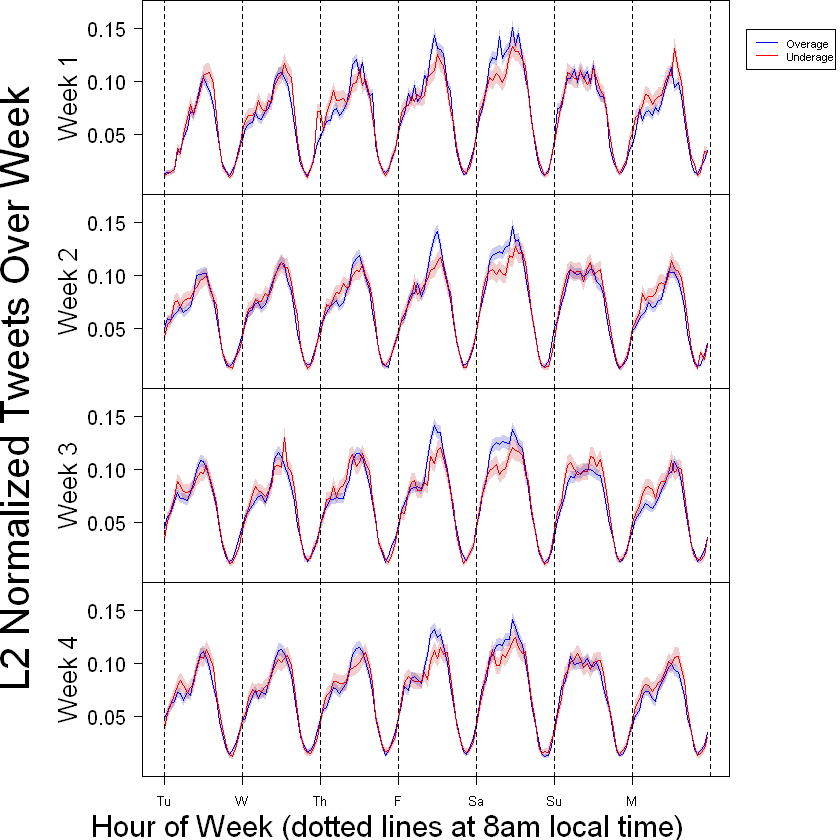

In [149]:
over_under_plot <- function(weeks.o, weeks.u, weeks.t){
    normalize <- function(ts){
        return(ts/norm(ts, type='2'))
    }
    # overage series, underage series, total tweets
    normed_weeks.o = apply(weeks.o, 2, normalize)
    normed_weeks.u = apply(weeks.u, 2, normalize)
    week_names = c('Week 1', 'Week 2', 'Week 3', 'Week 4')
    par(mfrow=c(4,1))
    # outer margin
    par(oma = c(4, 3, 0, 7))
    under_color <- rgb(190, 0, 0, alpha=50, maxColorValue=255)
    over_color <- rgb(0, 0, 190, alpha=50, maxColorValue=255)
    for (col in 1:4){
        # remove space for x-axis
        yrange = c(0, 0.17)
        par(mar = c(0, 6, 0, 0))
        o.std = 1.96*series.std(weeks.o[,col], weeks.t[,col])*weeks.t[,col]/norm(weeks.o[,col], type='2')
        o.above = normed_weeks.o[, col] + o.std
        o.below = normed_weeks.o[, col] - o.std
        
        u.std = 1.96*series.std(weeks.u[,col], weeks.t[,col])*weeks.t[,col]/norm(weeks.u[,col], type='2')
        u.above = normed_weeks.u[, col] + u.std
        u.below = normed_weeks.u[, col] - u.std
        
        plot(normed_weeks.o[, col], type='l', xaxt='n', ylim=yrange, yaxt='n', ylab='', col='blue')
        lines(normed_weeks.u[, col], col='red')
        polygon(c(1:168, rev(1:168)), c(o.above, rev(o.below)), col = over_color, border = NA)
        polygon(c(1:168, rev(1:168)), c(u.above, rev(u.below)), col = under_color, border = NA)
        
        title(ylab=week_names[col], line=4, las=1, cex.lab=2)
        axis(2, labels = c('0.05', '0.10', '0.15'), at=c(0.05, 0.1, 0.15), las = 1, cex.axis=1.5)
        abline(v=seq(1, (168+24), by=24), lty=2)
    }

    mtext('L2 Normalized Tweets Over Week', side = 2, outer = TRUE, line = 1, cex=2)
    mtext('Hour of Week (dotted lines at 8am local time)', side = 1, outer = TRUE, line = 3, cex=1.5)
    axis(1, labels = c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'), at=seq(1, 168, by=24), outer=TRUE)
    par(xpd=NA)
    legend(180,0.7,
       c("Overage", "Underage"),
       col = c("blue", "red"),
       cex = 0.8,
       lwd = 1, lty = 1)

}
over_under_plot(weeks.o, weeks.u, weeks.t)
# save_png(over_under_plot, 'C:/users/tom work/pycharmprojects/twipsy-lite/plots/over-under.png')